# How to analyze with BigQuery in Jupyter Notebook.

This notebook shows how to carry out interactive data analysis of data in BigQuery using a Jupyter Notebook managed by Vertex AI Workbench using [flights dataset](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=) in BTS website.

You can find how to ingest this dataset [here](https://github.com/GoogleCloudPlatform/data-science-on-gcp/tree/main/05_bqnotebook). 

Let's take a look at our working directory.

In [1]:
!pwd

/home/jupyter


Let's import the libraries we'll use in this analysis.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Magics Command in Jupyter Notebook

You can install a library using `pip` as follows:

In [3]:
%pip install pytz

Note: you may need to restart the kernel to use updated packages.


You can use another language magic command like %%. Let's, for example, type a html code.

In [4]:
%%html
This is a <b> HTML </b> string.

## Using BigQuery commands in Notebook.

You can convert SQL results into a Pandas DataFrame using `%%bigquery` as follows:

In [5]:
%%bigquery
SELECT 
   ORIGIN,
   AVG(DEP_DELAY) AS dep_delay,
   AVG(ARR_DELAY) AS arr_delay,
   COUNT(ARR_DELAY) AS num_flights
 FROM
   dsongcp.flights_tzcorr
 GROUP BY
   ORIGIN
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:03<00:00,  1.46rows/s]


,ORIGIN,dep_delay,arr_delay,num_flights
0,LFT,7.627476,7.126566,5428
1,FCA,1.385915,-2.739028,2119
2,MBS,7.557350,4.908584,1794
3,LIT,9.049897,5.260500,11167
4,DTW,8.794979,3.216070,116874


You can also directly query BigQuery with the Python library:

In [6]:
from google.cloud import bigquery

# Write a SQL query 
sql = """
SELECT 
   ORIGIN,
   AVG(DEP_DELAY) AS dep_delay,
   AVG(ARR_DELAY) AS arr_delay,
   COUNT(ARR_DELAY) AS num_flights
 FROM
   dsongcp.flights_tzcorr
 GROUP BY
   ORIGIN
LIMIT 5
"""

# Clienting to bundle configuration needed for API requests.
bq = bigquery.Client()

# Querying the sql command and then converting into Pandas DataFrame
bq.query(sql).to_dataframe()

,ORIGIN,dep_delay,arr_delay,num_flights
0,LFT,7.627476,7.126566,5428
1,FCA,1.385915,-2.739028,2119
2,MBS,7.557350,4.908584,1794
3,LIT,9.049897,5.260500,11167
4,DTW,8.794979,3.216070,116874


I'm going to plot a Probability Distribution Function (PDF) of different arrival delays. We can assign the output to a variable, df.

In [7]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE DEP_DELAY >= 10

Downloading: 100%|██████████| 1294778/1294778 [00:02<00:00, 537033.80rows/s] 


Let's take a look at the type of the variable.

In [8]:
type(df)

pandas.core.frame.DataFrame

You can use Pandas methods you want.

In [9]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,1.286778e+06,1.294778e+06
mean,4.611797e+01,5.094516e+01
std,6.360700e+01,6.151423e+01
min,-7.800000e+01,1.000000e+01
25%,1.100000e+01,1.700000e+01
50%,2.700000e+01,3.000000e+01
75%,5.900000e+01,6.100000e+01
max,1.971000e+03,1.988000e+03


## Data Visualization

Let's draw a violinplot for the `ARR_DELAY` variable.

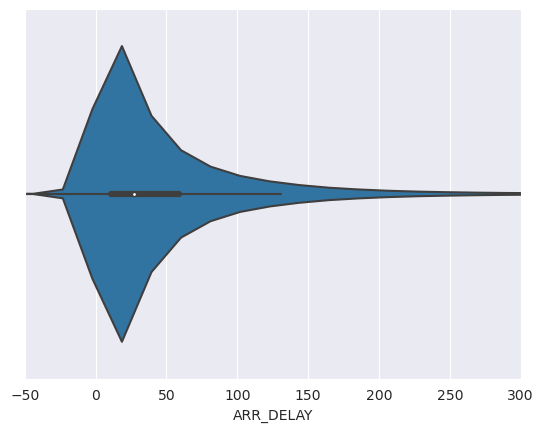

In [10]:
sns.set_style("darkgrid")
# sns.set(font_scale = 1.5)
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
ax.axes.set_xlim(-50, 300);

### Plotting distributions

In [11]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr

Downloading: 100%|██████████| 5819079/5819079 [00:04<00:00, 1267678.87rows/s]


Let's create a variable that shows a delay of less than 10 minutes.

In [12]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

,ARR_DELAY,DEP_DELAY,ontime
1,264.0,245.0,False
5,54.0,54.0,False
6,128.0,145.0,False
7,40.0,39.0,False
8,29.0,23.0,False


Let's draw the violinplot using the `ontime` variable.

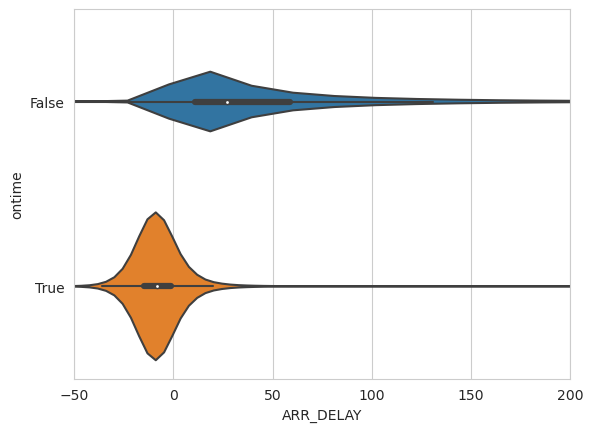

In [13]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200);

## Finding Outlier values

In [14]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  dsongcp.flights_tzcorr
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY

Downloading: 100%|██████████| 1218/1218 [00:03<00:00, 372.02rows/s]


In [15]:
depdelay.shape

(1218, 3)

In [16]:
depdelay.head()

,DEP_DELAY,arrival_delay,numflights
0,NaN,NaN,0
1,-82.0,-80.0,1
2,-68.0,-87.0,1
3,-61.0,-77.0,1
4,-56.0,-26.0,1


### Filtering Data on Occurence Frequency

In [17]:
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (
    SELECT COUNT(*) FROM dsongcp.flights_tzcorr
);

CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64>
AS ((
    SELECT AS STRUCT
        THRESH,
        (NUM_TOTAL - SUM(numflights)) AS num_removed,
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2) AS lm
    FROM
    (
        SELECT
            DEP_DELAY,
            AVG(ARR_DELAY) AS arrival_delay,
            STDDEV(ARR_DELAY) AS stddev_arrival_delay,
            COUNT(ARR_DELAY) AS numflights
        FROM
            dsongcp.flights_tzcorr
        GROUP BY
            DEP_DELAY
    )
    WHERE numflights > THRESH
));

SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

Downloading: 100%|██████████| 9/9 [00:03<00:00,  2.90rows/s]


Let's take a look at the thresh and the number of removed values.

In [18]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

0    (1000, 175873, 0.25)
1     (500, 143801, 0.34)
2     (370, 135518, 0.36)
3     (300, 129835, 0.38)
4      (200, 123640, 0.4)
5     (100, 115471, 0.43)
6      (22, 108247, 0.45)
7      (10, 106958, 0.46)
8       (5, 106319, 0.46)
Name: stats, dtype: object

## Arrival delay conditioned on departure delay

In [19]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:05<00:00, 44.30rows/s]


In [20]:
depdelay.head()

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950


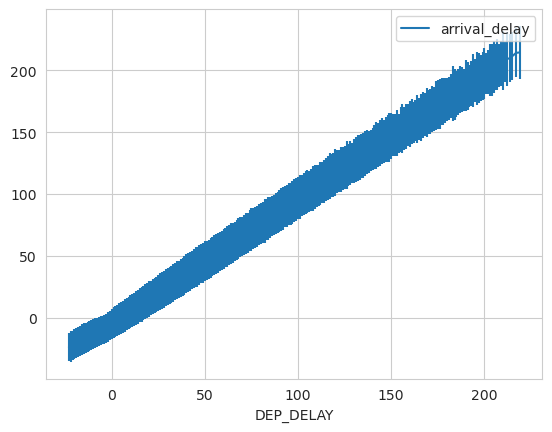

In [21]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

### Applying a probabilistic decision threshold

Note that our decision criteria are 15 minutes and 30%. Let's find a threshold with the assumption that it is normally distributed.

In [22]:
depdelay.head()

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950


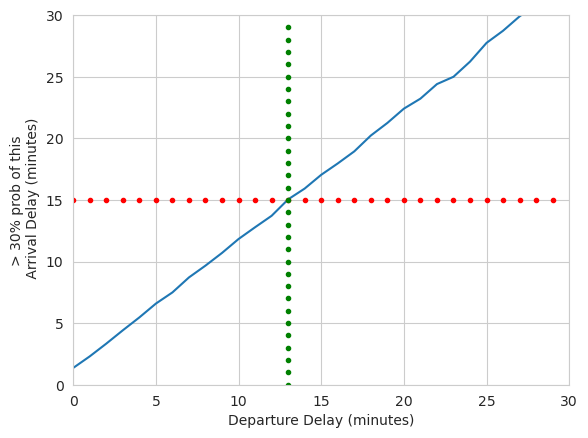

In [23]:
# Obtaining Z-value for 30% likely.
Z_30 = 0.52

# Caluculating Z-score
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']

# Plotting arrival values
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 13
ax.plot(x, y, 'g.');

As you can see from graph, our decision criteria translate to a departure delay of 13 minutes. 

### Empirical probability distribution function

Let's find a threshold without the assumption that it is normally distributed.

In [24]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:05<00:00, 44.35rows/s]


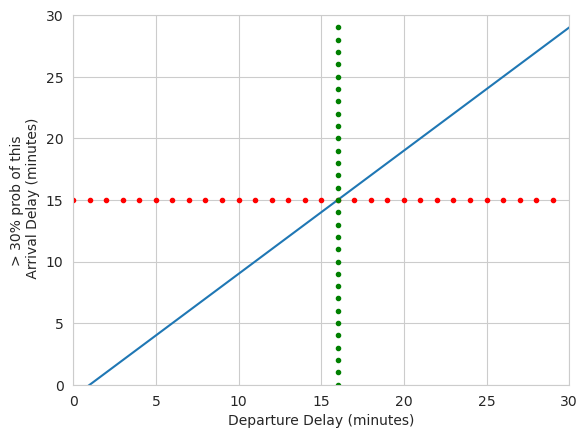

In [25]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 16
ax.plot(x, y, 'g.');

As you can see from this graph, our decision threshold, without the assumption of normal distribution, is 16 minutes.

## Creating training/evaluation dataset

Let's take a look at all the unique days in the dataset:

In [26]:
%%bigquery
SELECT
  DISTINCT(FL_DATE) AS FL_DATE
FROM
  dsongcp.flights_tzcorr
ORDER BY
  FL_DATE
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:03<00:00,  3.07rows/s]


,FL_DATE
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
5,2015-01-06
6,2015-01-07
7,2015-01-08
8,2015-01-09
9,2015-01-10


In [27]:
%%bigquery
SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:03<00:00,  1.51rows/s]


,FL_DATE,is_train_day
0,2015-01-01,True
1,2015-01-02,False
2,2015-01-03,False
3,2015-01-04,True
4,2015-01-05,True


Let's take a look at the number of categories of train day.

In [28]:
%%bigquery
WITH train_day AS (
SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE
)

SELECT
    COUNT(*) 
FROM train_day

GROUP BY
    is_train_day

Downloading: 100%|██████████| 2/2 [00:05<00:00,  2.58s/rows]


,f0_
0,263
1,102


Let's create the training table

In [29]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.trainday AS

SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 741.04query/s]                         


""


Let's assign the training data to the depdelay variable.

In [30]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
JOIN dsongcp.trainday USING(FL_DATE)
WHERE is_train_day = 'True'
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

Downloading: 100%|██████████| 224/224 [00:01<00:00, 116.41rows/s]


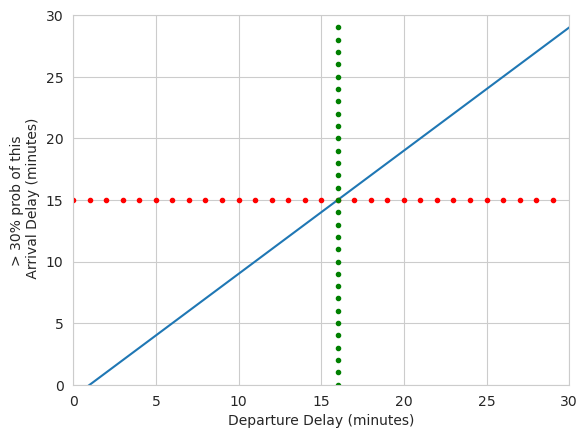

In [31]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 16
ax.plot(x, y, 'g.');

We obtain the same answer—16 minutes—after creating the empirical probabilistic model on just the training data. Now let’s formally evaluate how well our recommendation of 16 minutes does in terms of predicting an arrival delay of 15 minutes or more. 

In [32]:
%%bigquery df_eval
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    dsongcp.flights_tzcorr
  JOIN dsongcp.trainday USING(FL_DATE)
  WHERE is_train_day = 'False' 
)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.54s/rows]


Let's take a look at the results we got.

In [33]:
print(df_eval['correct_nocancel'] /
      (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / 
      (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

0    0.950158
dtype: float64
0    0.804703
dtype: float64


It turns out when you not cancel your meeting, you will be correct 95% of the time, and when you cancel your meeting, you will be correct 82% of the time.

In [34]:
df_eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1259740,66081,52827,217669


Let's evaluate right at the decision boundary by changing our scoring function with test dataset:

In [35]:
%%bigquery df_eval
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    dsongcp.flights_tzcorr
  JOIN dsongcp.trainday USING(FL_DATE)
  WHERE is_train_day = 'False' 
)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.83s/rows]


In [36]:
df_eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,7684,2935,6787,2942


In [37]:
print(df_eval['correct_nocancel'] / (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

0    0.723609
dtype: float64
0    0.302395
dtype: float64


As expected, we are correct to not cancel the meeting 72% of the time, close to our target of 70%.

### Resources

- [Data science on google cloud](https://www.amazon.it/Data-Science-Google-Cloud-Platform-dp-1098118952/dp/1098118952/ref=dp_ob_title_bk)